**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [134]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
retTrue_images=[]
corner_images = []
undist_images=[]
counter =0
# Step through the list and search for chessboard corners and undistort images

for num in range(len(images)):
    img = cv2.imread(images[num])
    _img = copy.copy(img)
    img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)    

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)     

    # If found, add object points, image points    
    if ret == True:        
        retTrue_images.append(_img)        
        objpoints.append(objp)
        imgpoints.append(corners)        
        # Draw the corners
        c_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(c_img)
        cv2.imwrite('output_images/draw_coners'+str(num)+'.jpg',c_img)
    else:
        counter+=1

print(str(counter)+" of "+str(len(images))+" failed to find corners for 9x6 chessboard")
for num in range(len(retTrue_images)):    
    # Undistort images           
    img = retTrue_images[num]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)    
    undist_images.append(dst)
    cv2.imwrite('output_images/undistort'+str(num)+'.jpg',dst)

3 of 20 failed to find corners for 9x6 chessboard


   Original images          Corner Drawing         Undistorted images


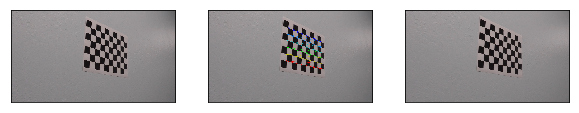

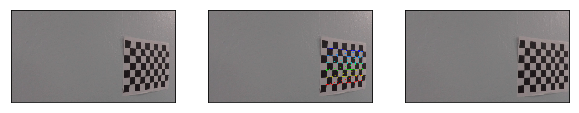

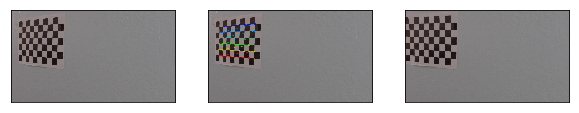

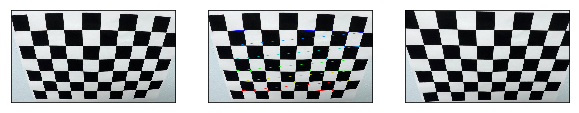

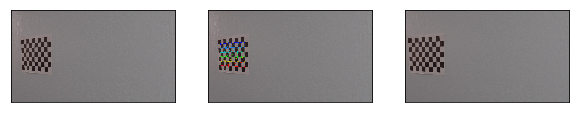

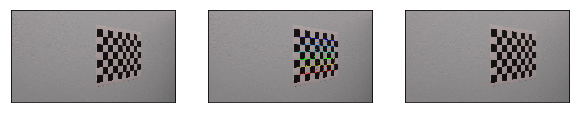

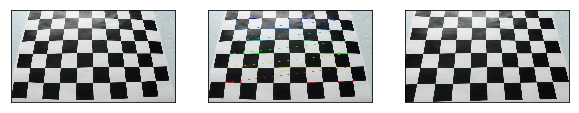

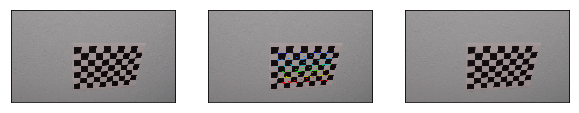

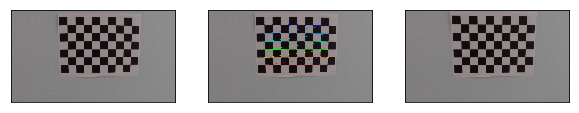

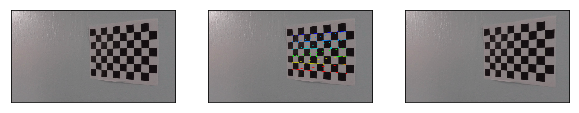

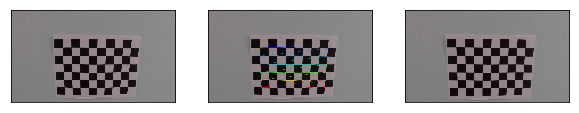

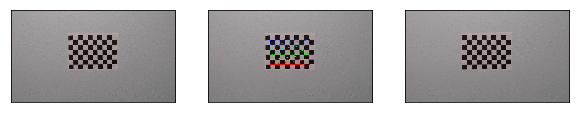

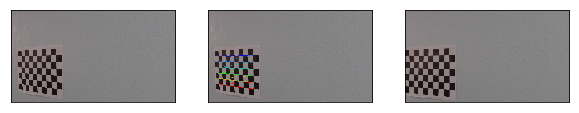

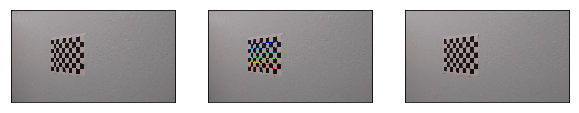

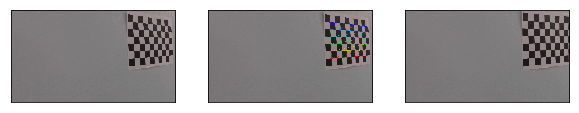

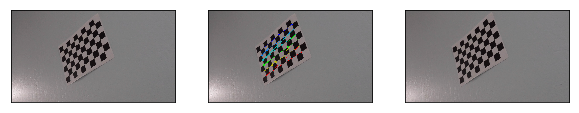

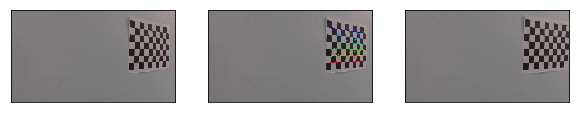

In [135]:
temp = np.vstack((retTrue_images, corner_images))
temp = np.vstack((temp, undist_images))
print('   Original images          Corner Drawing         Undistorted images')
for num in range(len(retTrue_images)):
    plt.figure(num)    
    fig, axes = plt.subplots(1,3, figsize=(10,10),subplot_kw={'xticks': [], 'yticks': []})            
    for idx,ax in enumerate(axes.flat):  
        image = temp[idx][num]
        ax.imshow(image)              

In [136]:
#Pipeline
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)    

#for reference
images = glob.glob('test_images/*.jpg')
test_images=[]
test_undistort = []
for num, img in enumerate(images):    
    img = copy.copy(cv2.imread(img))    
    dst = undistort(img)    
    test_images.append(img)
    test_undistort.append(dst)   
    cv2.imwrite('output_images/test_undistort'+str(num)+'.jpg',dst)

            Original images                  Undistorted images


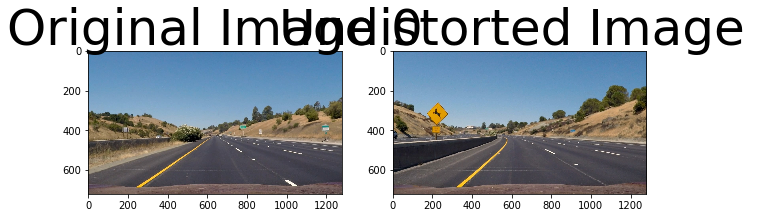

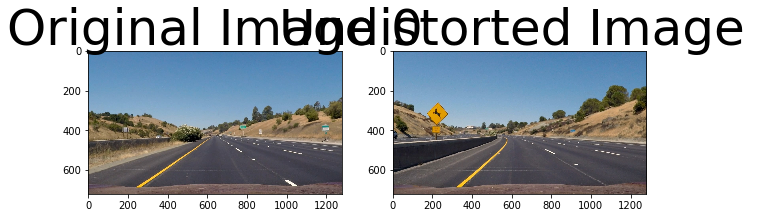

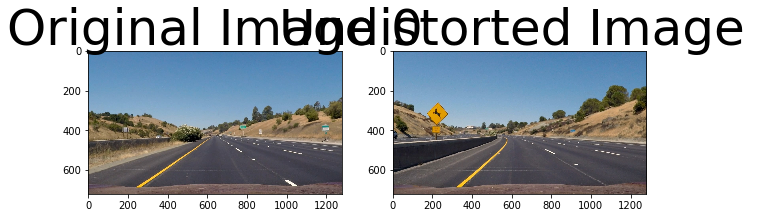

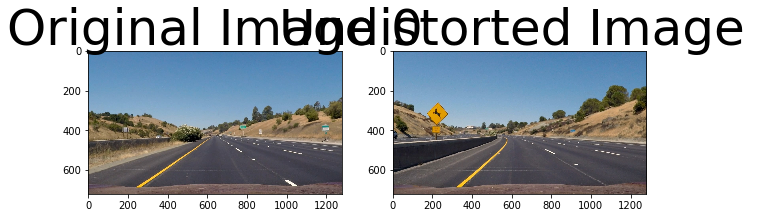

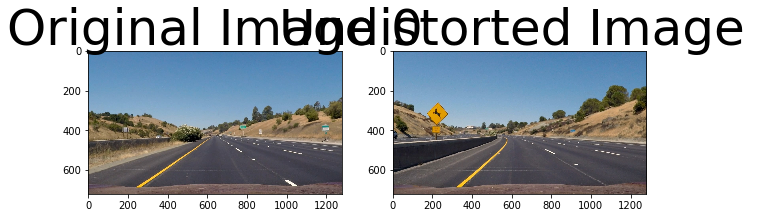

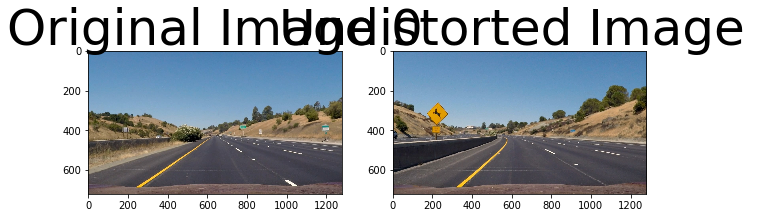

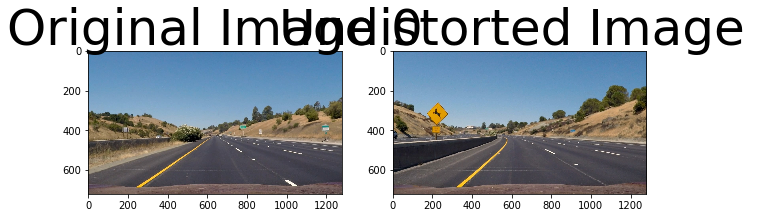

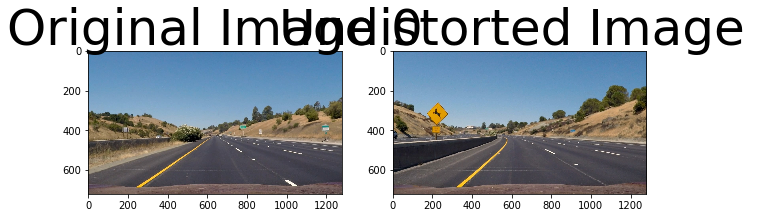

In [137]:
temp = np.vstack((test_images,test_undistort))
print('            Original images                  Undistorted images')
for num in range(len(test_images)):
    plt.figure(num)    
    fig, axes = plt.subplots(1,2, figsize=(10,10))            
    for num, ax in enumerate(axes.flat):   
        if(num==0):
            ax.set_title('Original Image '+str(num), fontsize=50)
        else:
            ax.set_title('Undistorted Image ', fontsize=50)
        ax.imshow(cv2.cvtColor(temp[num], cv2.COLOR_BGR2RGB))               

In [138]:
#Pipeline
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 200)):    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def s_threshold(img, thresh=(0,255)):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

def binary(img):
    ksize = 7
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(30, 100))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=((0.8, 1.1)))
    s_binary = s_threshold(s_channel, thresh=((170,250)))
    combined = np.zeros_like(l_channel)
    combined[((gradx == 1) & (grady == 1)) |
             ((mag_binary == 1) & (dir_binary == 1)) |
             (s_binary==1)] = 1    
    return combined

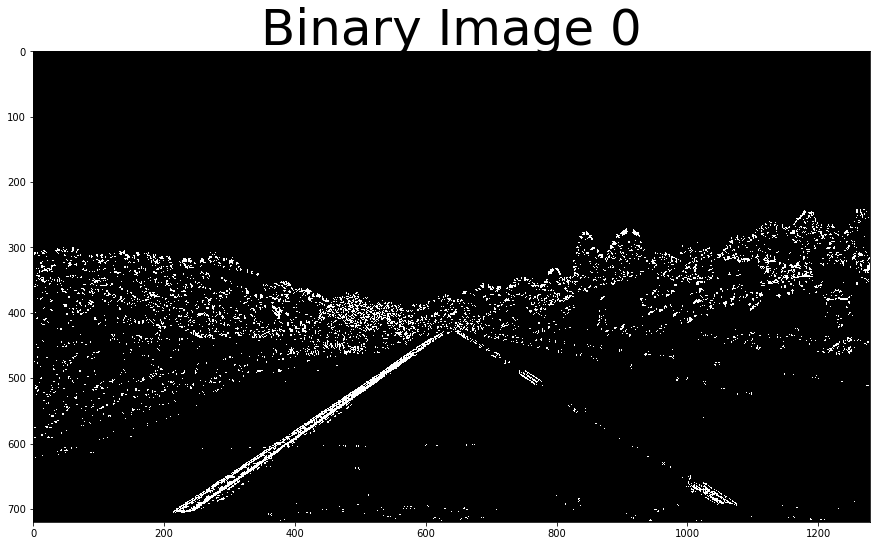

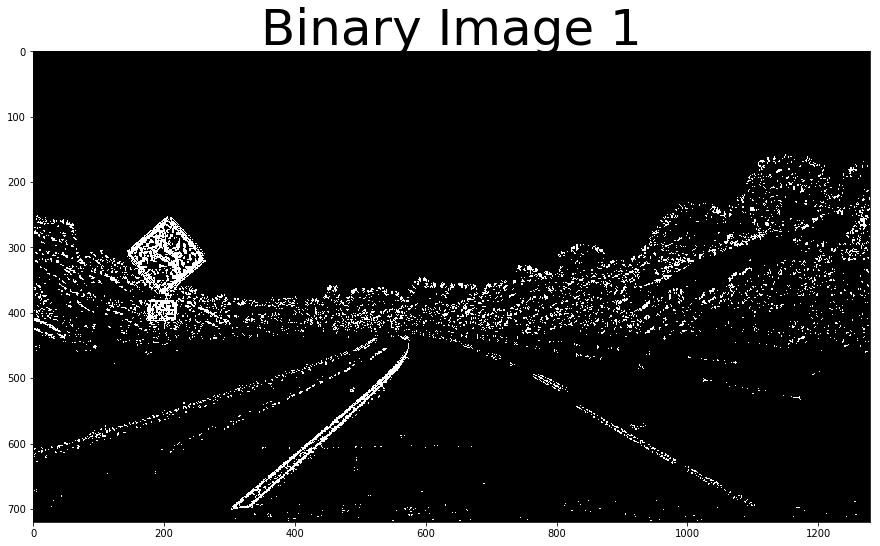

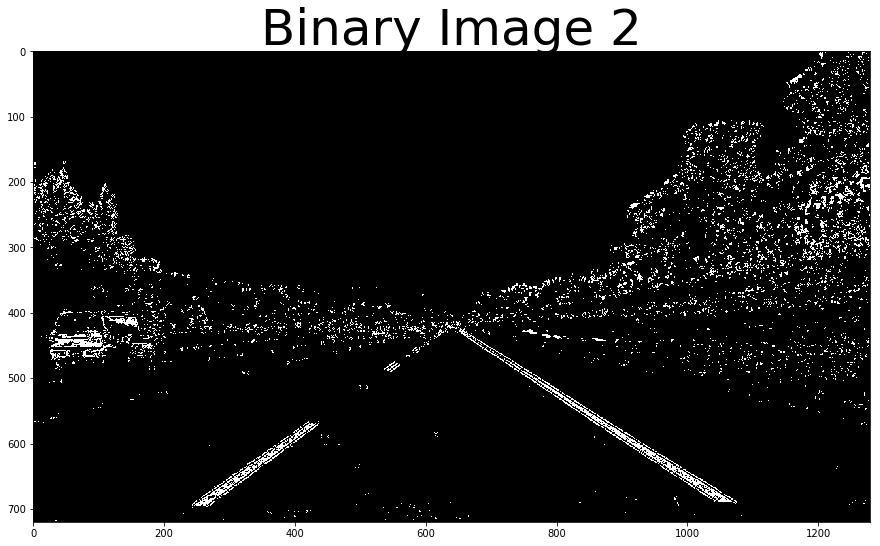

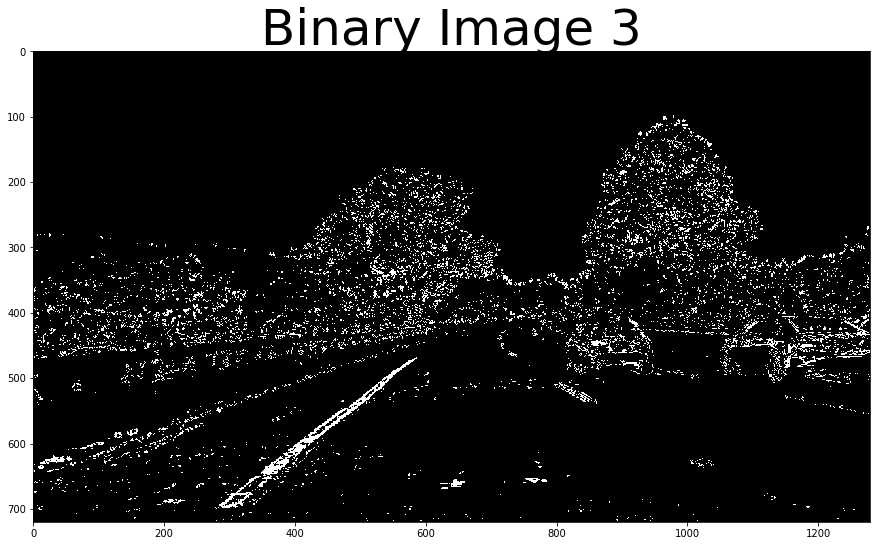

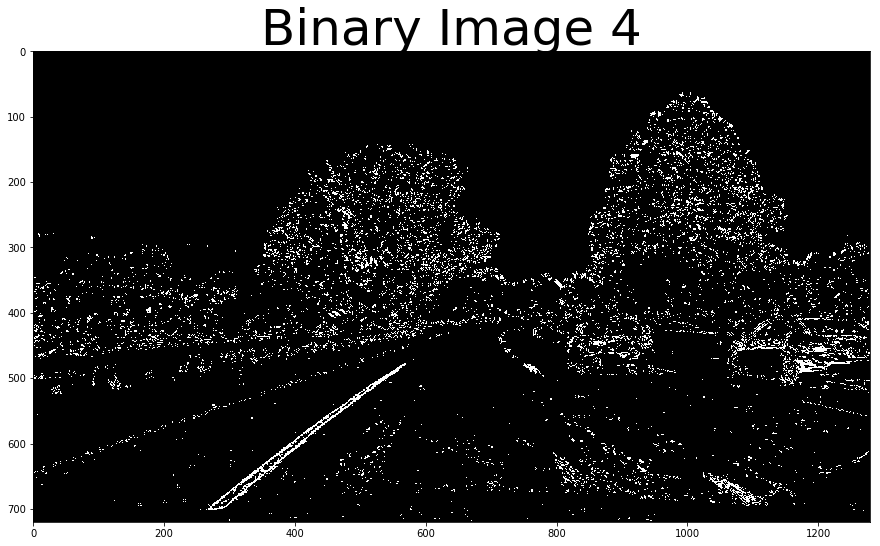

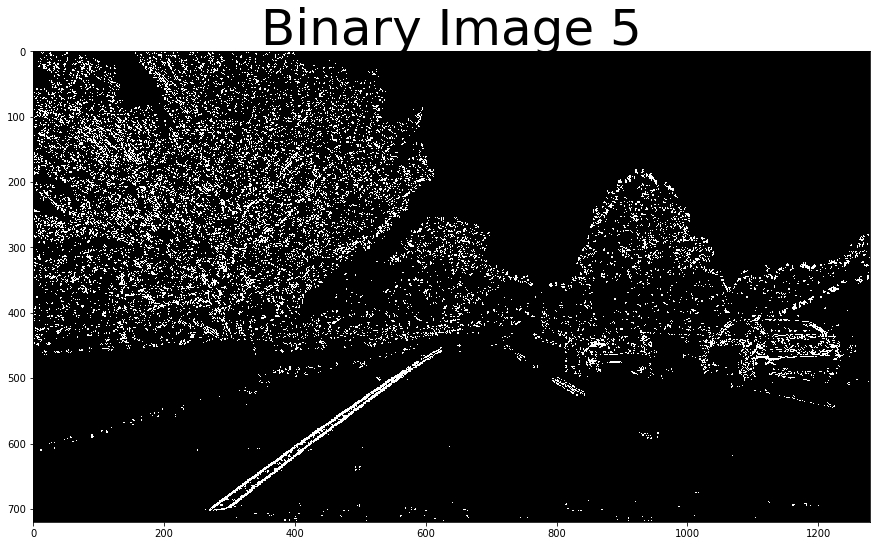

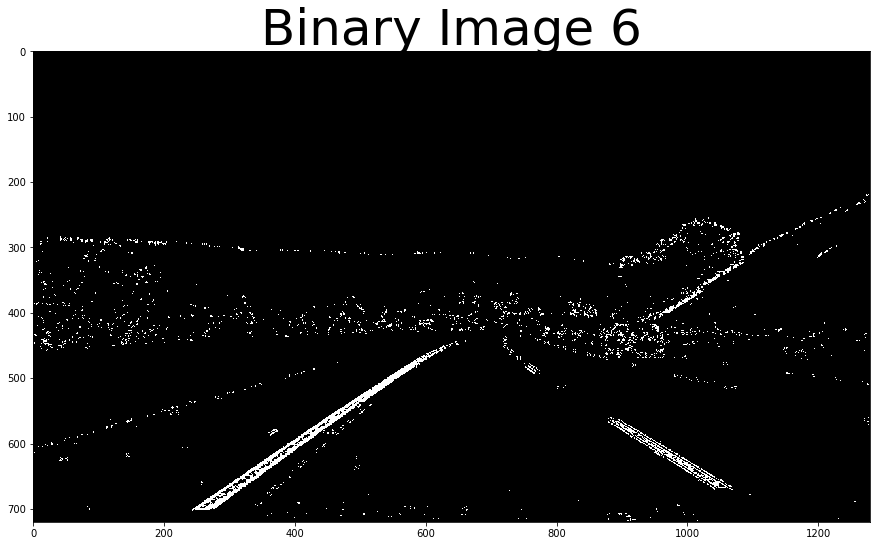

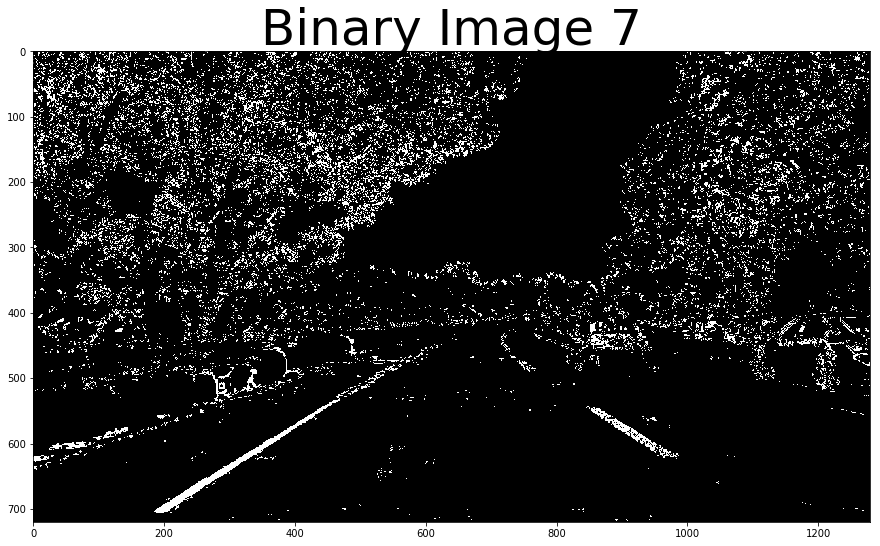

In [139]:
#for reference
test_binary=[]
for num, img in enumerate(test_undistort):    
    combined = binary(img)
    test_binary.append(combined)      
    cv2.imwrite('output_images/test_binary'+str(num)+'.jpg',combined*255)

for num in range(len(test_binary)):
    plt.figure(num)    
    fig, axes = plt.subplots(1,1, figsize=(15,15))
    axes.set_title('Binary Image '+str(num), fontsize=50)
    axes.imshow(test_binary[num],cmap = 'gray')

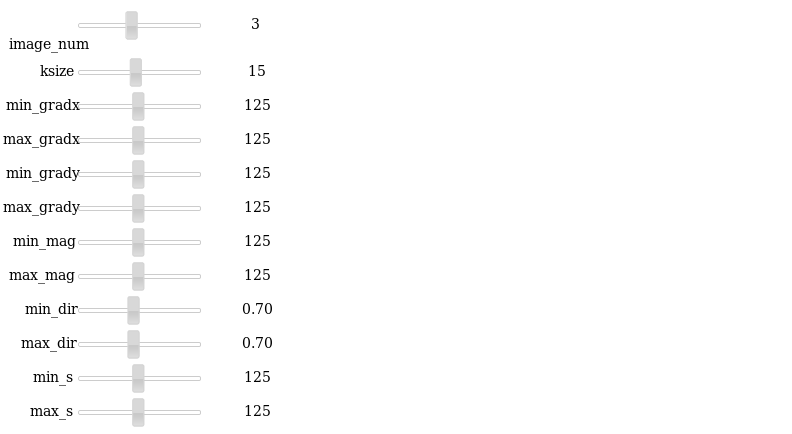

<function __main__.test>

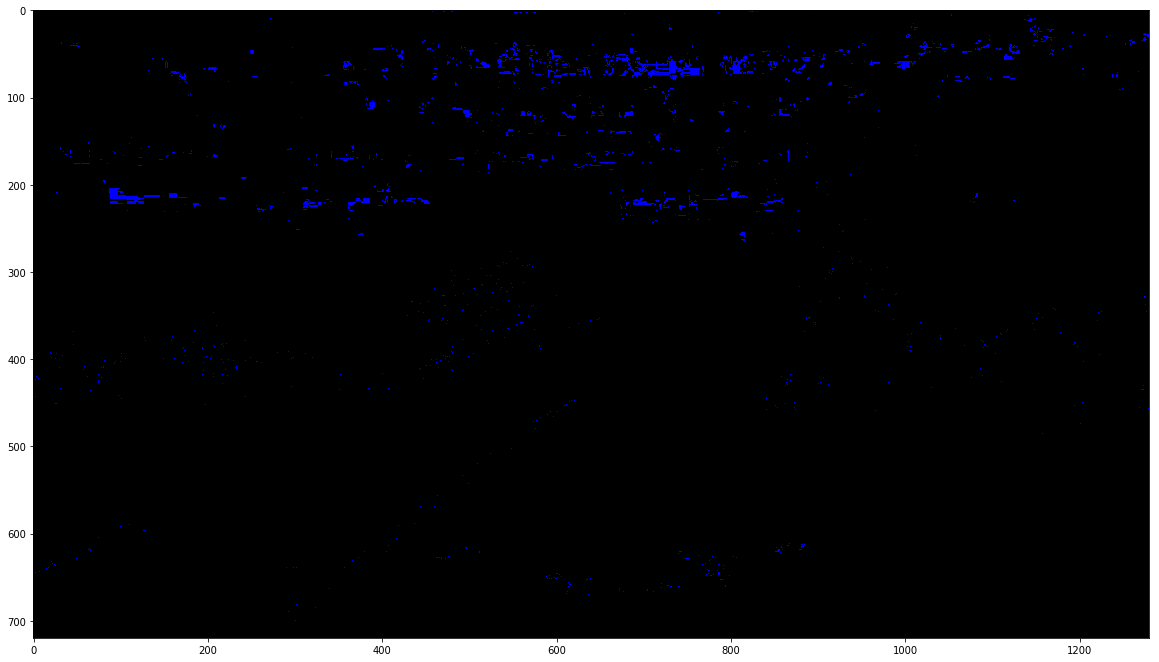

In [140]:
#test threshold
from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

array=[]
title=['Original','Combined','GradX','GradY','Magnitude','Directional']
def test(image_num, ksize, min_gradx, max_gradx, min_grady, max_grady, min_mag, max_mag, min_dir, max_dir,min_s,max_s):    
    img = test_undistort[image_num]
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(min_gradx, max_gradx))
    grady = abs_sobel_thresh(l_channel, orient='y', sobel_kernel=ksize, thresh=(min_grady, max_grady))
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(min_mag, max_mag))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=((min_dir, max_dir)))
    s_binary = s_threshold(s_channel, thresh=((min_s,max_s)))
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary==1)] = 1
    r=np.zeros_like(dir_binary)
    g=np.zeros_like(dir_binary)
    r[((gradx == 1) & (grady == 1))]=1
    g[((mag_binary == 1) & (dir_binary == 1))] = 1    
    color_binary = np.dstack((r,g,s_binary))
    plt.figure(figsize=(20,20))
    plt.imshow(color_binary)       

interact(test, image_num=(0,len(test_undistort)-1),ksize=(1,31,2),
        min_gradx=(0,255,5),max_gradx=(0,255,5),
        min_grady=(0,255,5),max_grady=(0,255,5),
        min_mag=(0,255,5), max_mag=(0,255,5),
        min_dir=(0,np.pi/2,0.1),max_dir=(0,np.pi/2,0.1),
        min_s=(0,255,5),max_s=(0,255,5))

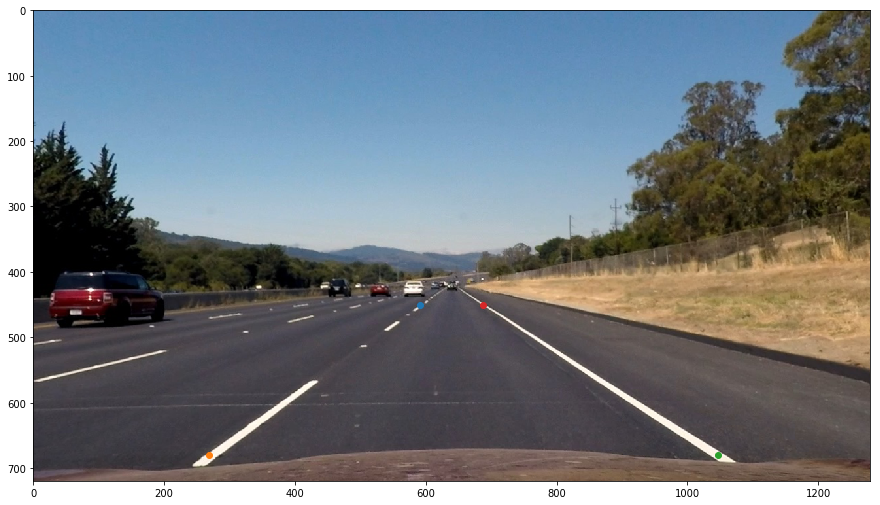

In [141]:
#for reference
img = cv2.cvtColor(test_undistort[2], cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(figsize=(15,15))
ax.plot(591,450,'o')
ax.plot(269,680,'o')
ax.plot(1047,680,'o')
ax.plot(688,450,'o')
ax.imshow(img)

In [142]:
#Pipeline
def transform(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[591,450],
                       [269,680],
                       [1047,680],
                       [688,450]])
    dst = np.float32([[(img_size[0] / 4), 0],
                      [(img_size[0] / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), img_size[1]],
                      [(img_size[0] * 3 / 4), 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

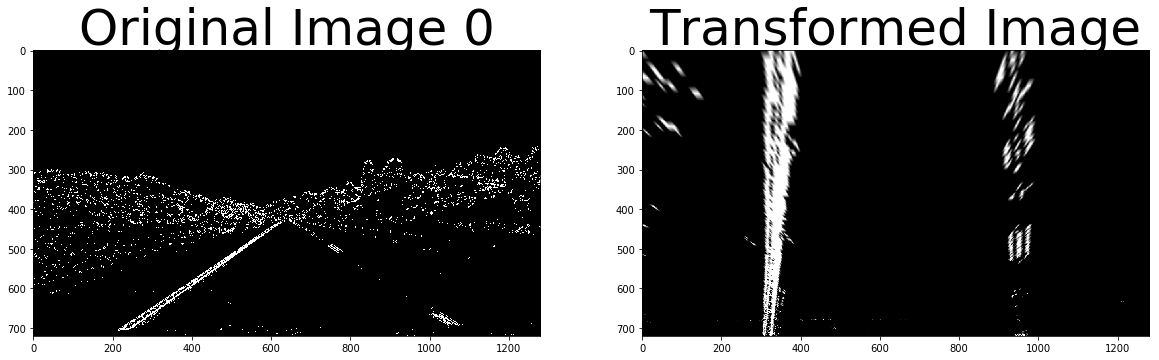

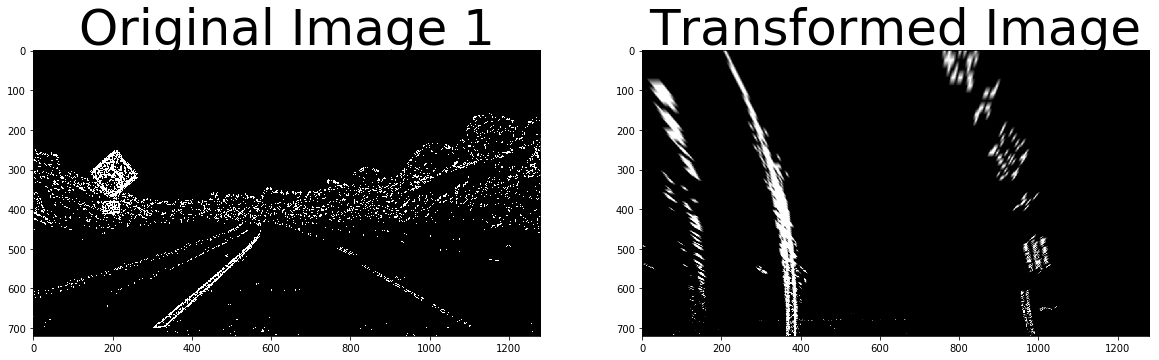

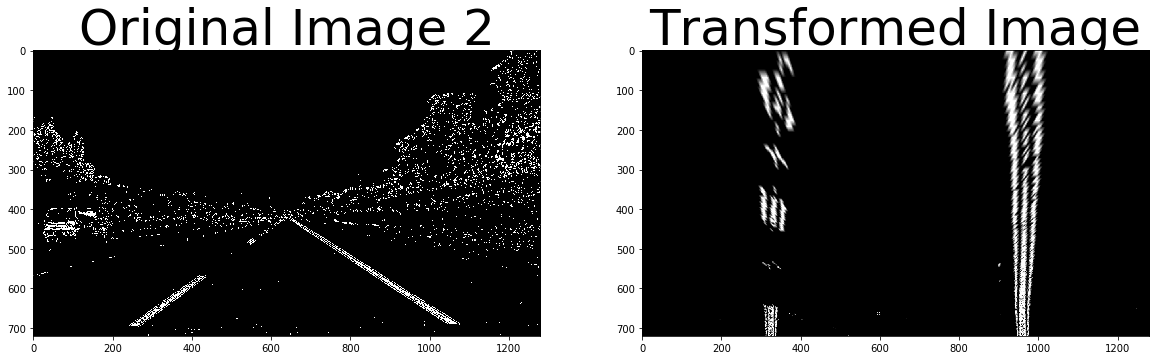

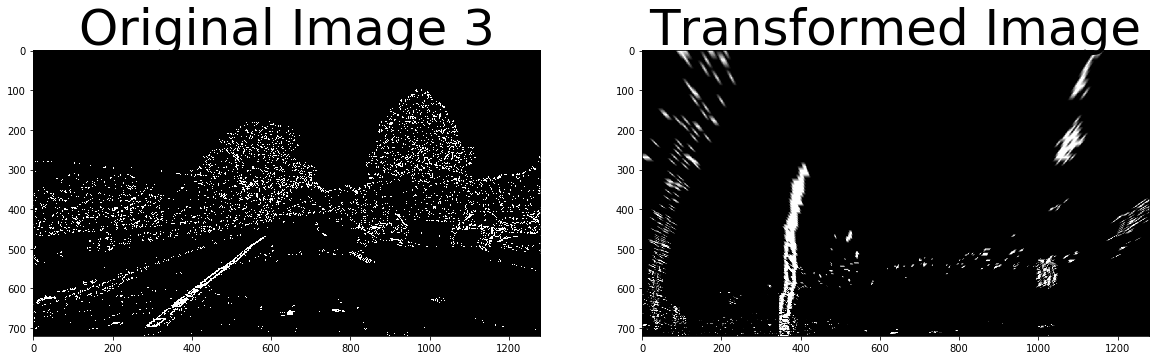

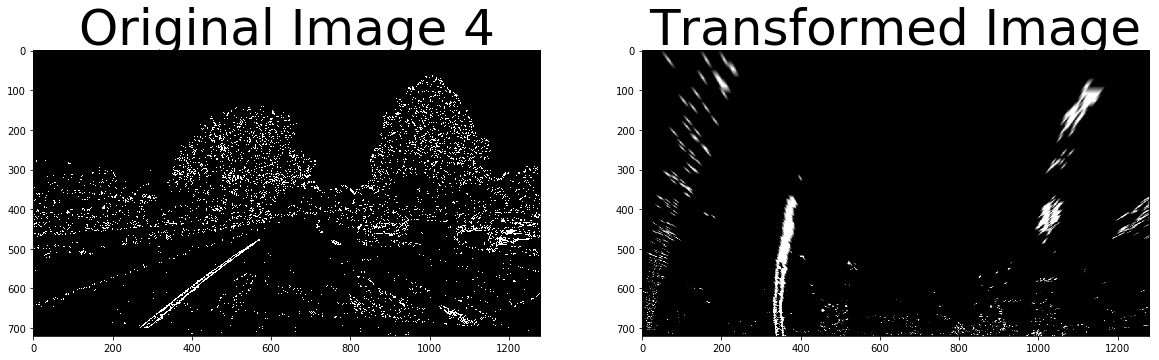

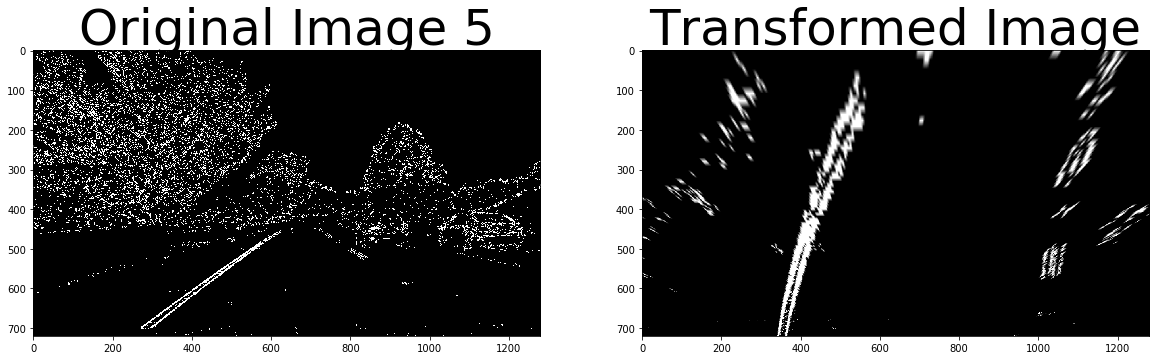

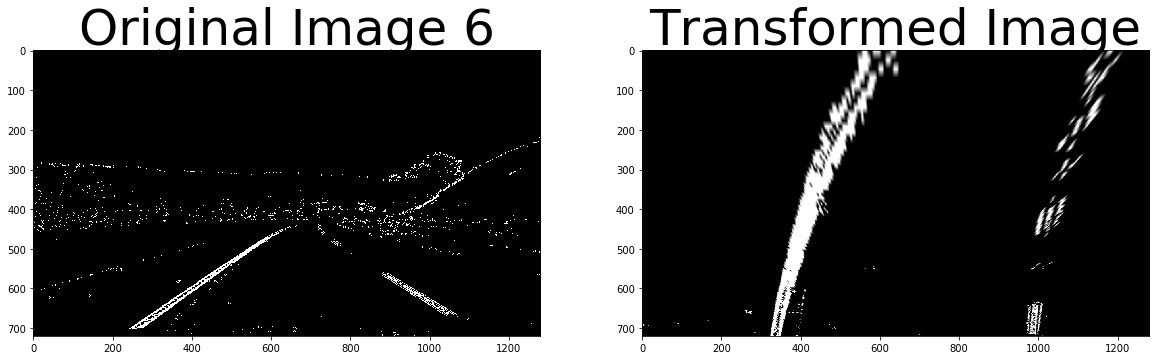

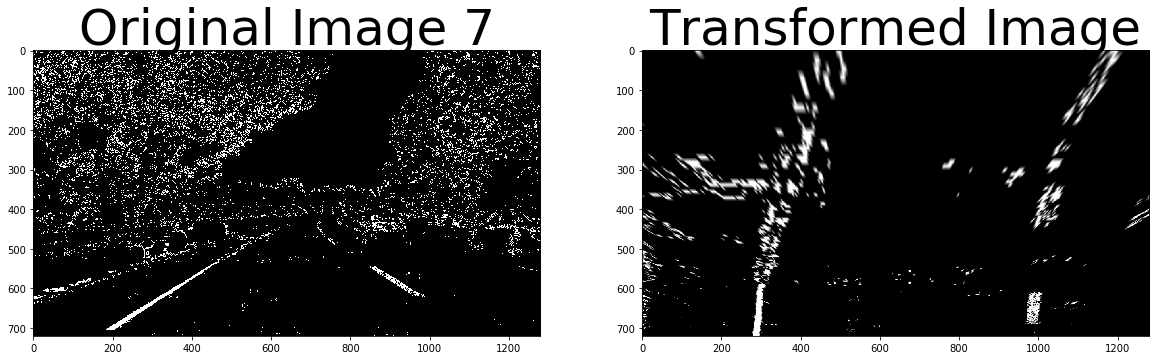

In [143]:
#for reference
test_binary_warped=[]
for num in range(len(test_binary)):    
    warped = transform(test_binary[num])  
    test_binary_warped.append(warped)
    cv2.imwrite('output_images/test_binary_warped'+str(num)+'.jpg',combined*255)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
    ax1.imshow(test_binary[num], cmap='gray')
    ax1.set_title('Original Image '+str(num), fontsize=50)
    ax2.imshow(warped,cmap='gray')
    ax2.set_title('Transformed Image', fontsize=50)    

/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


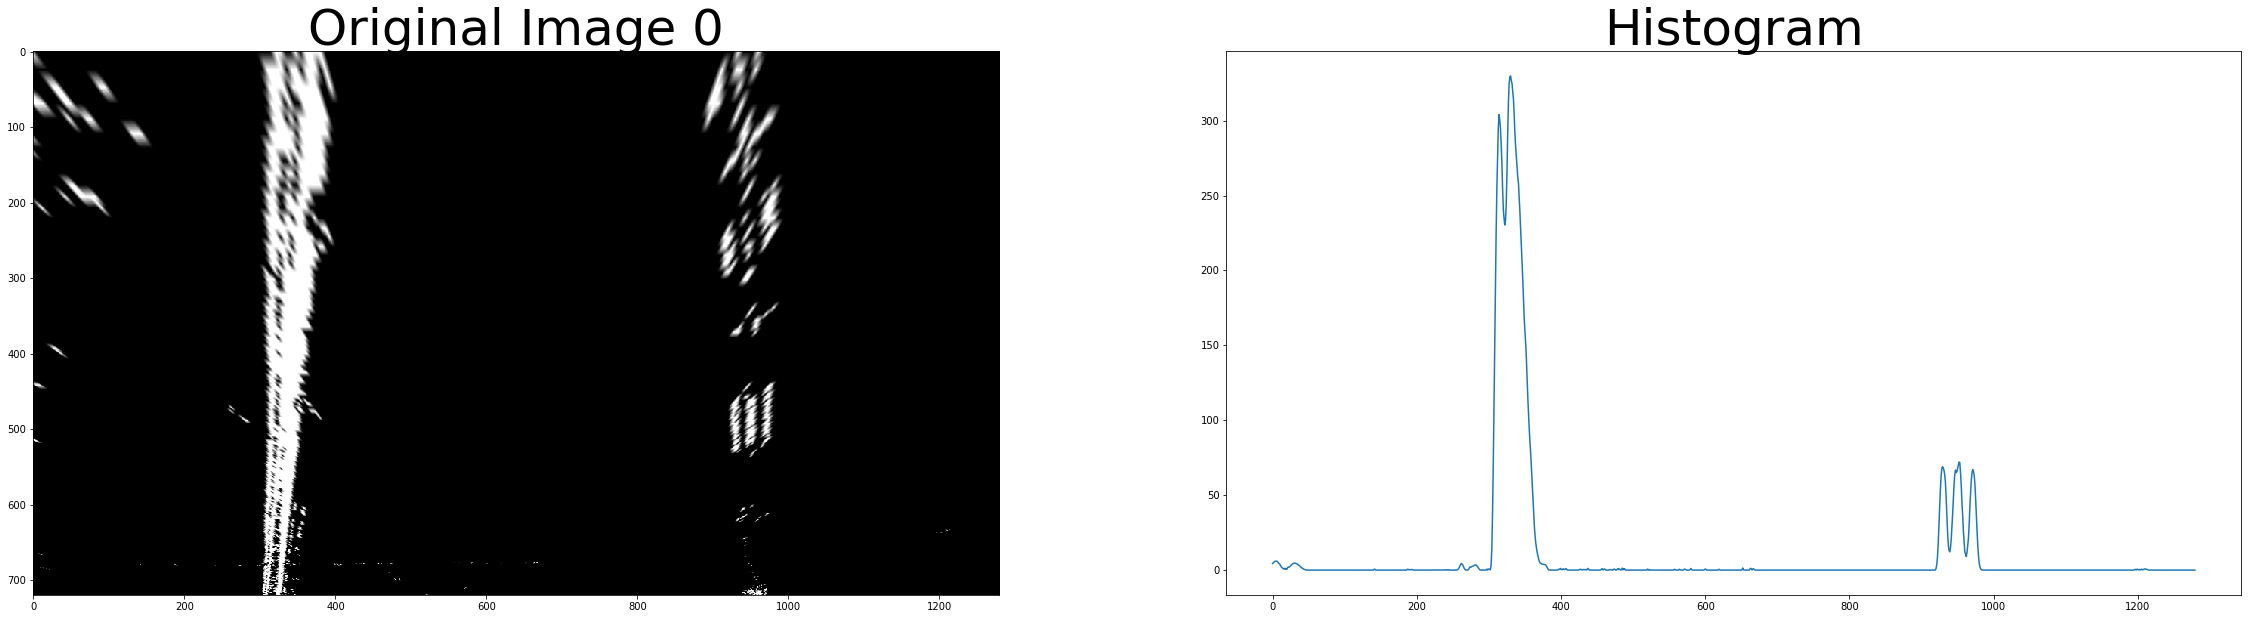

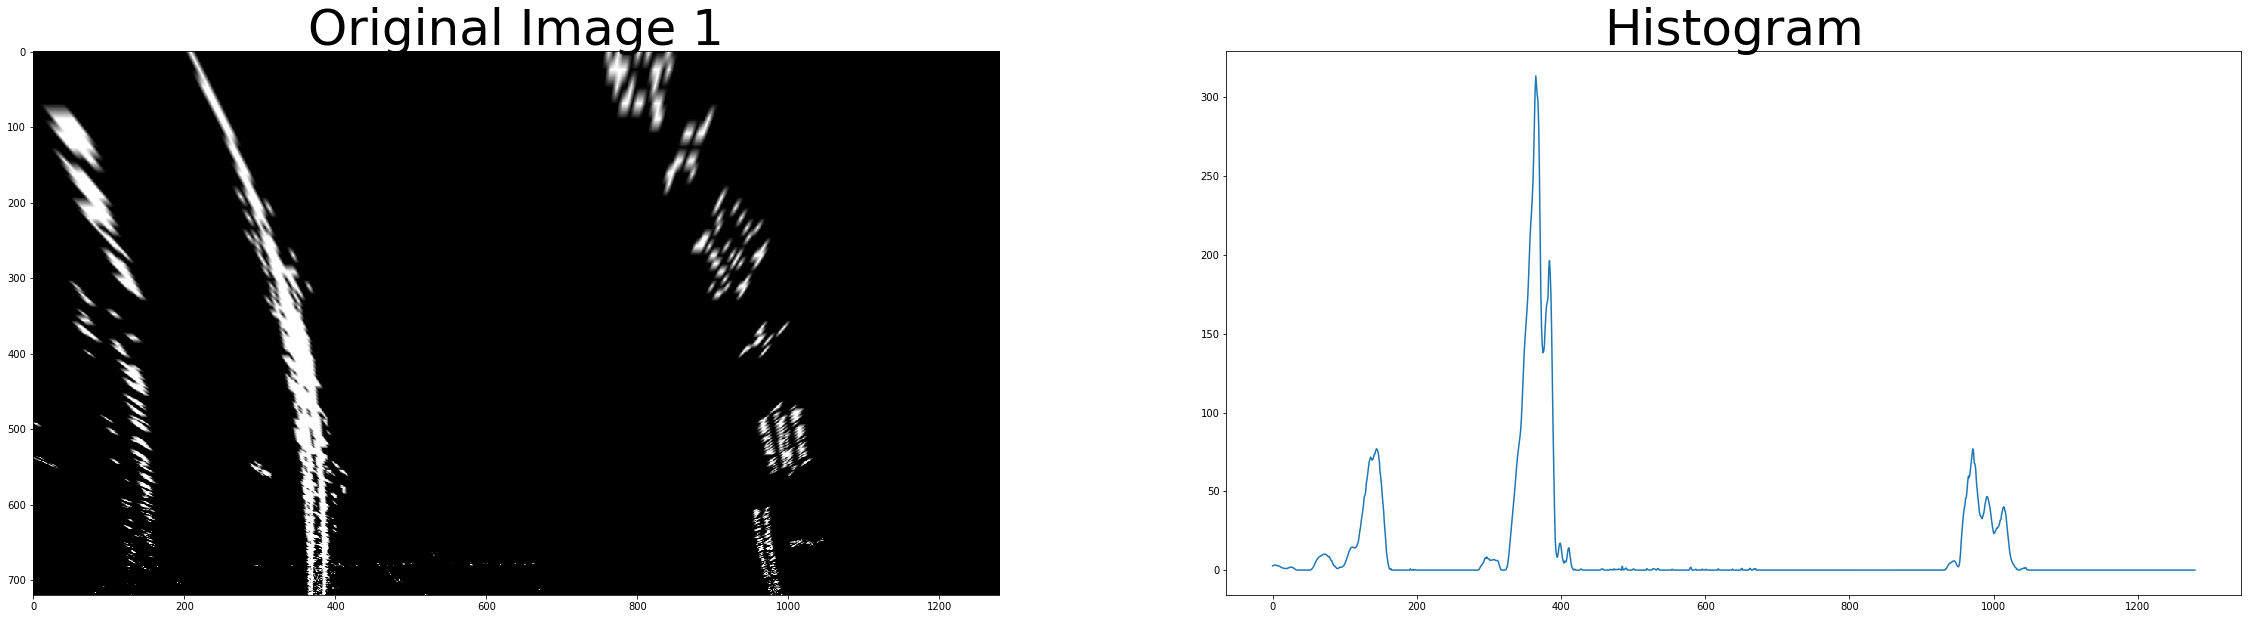

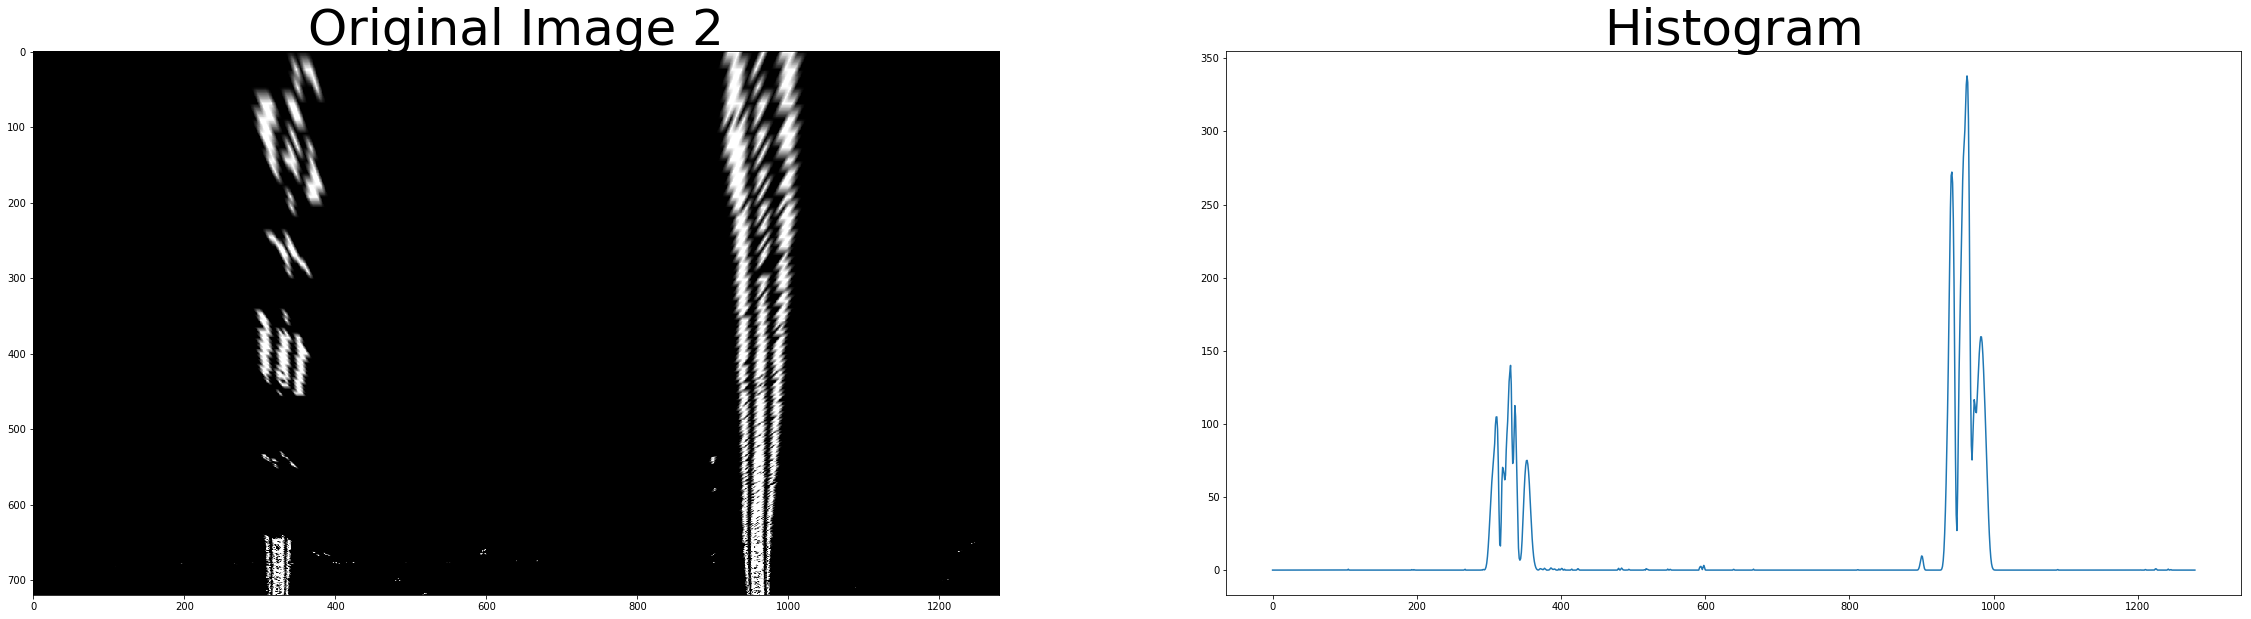

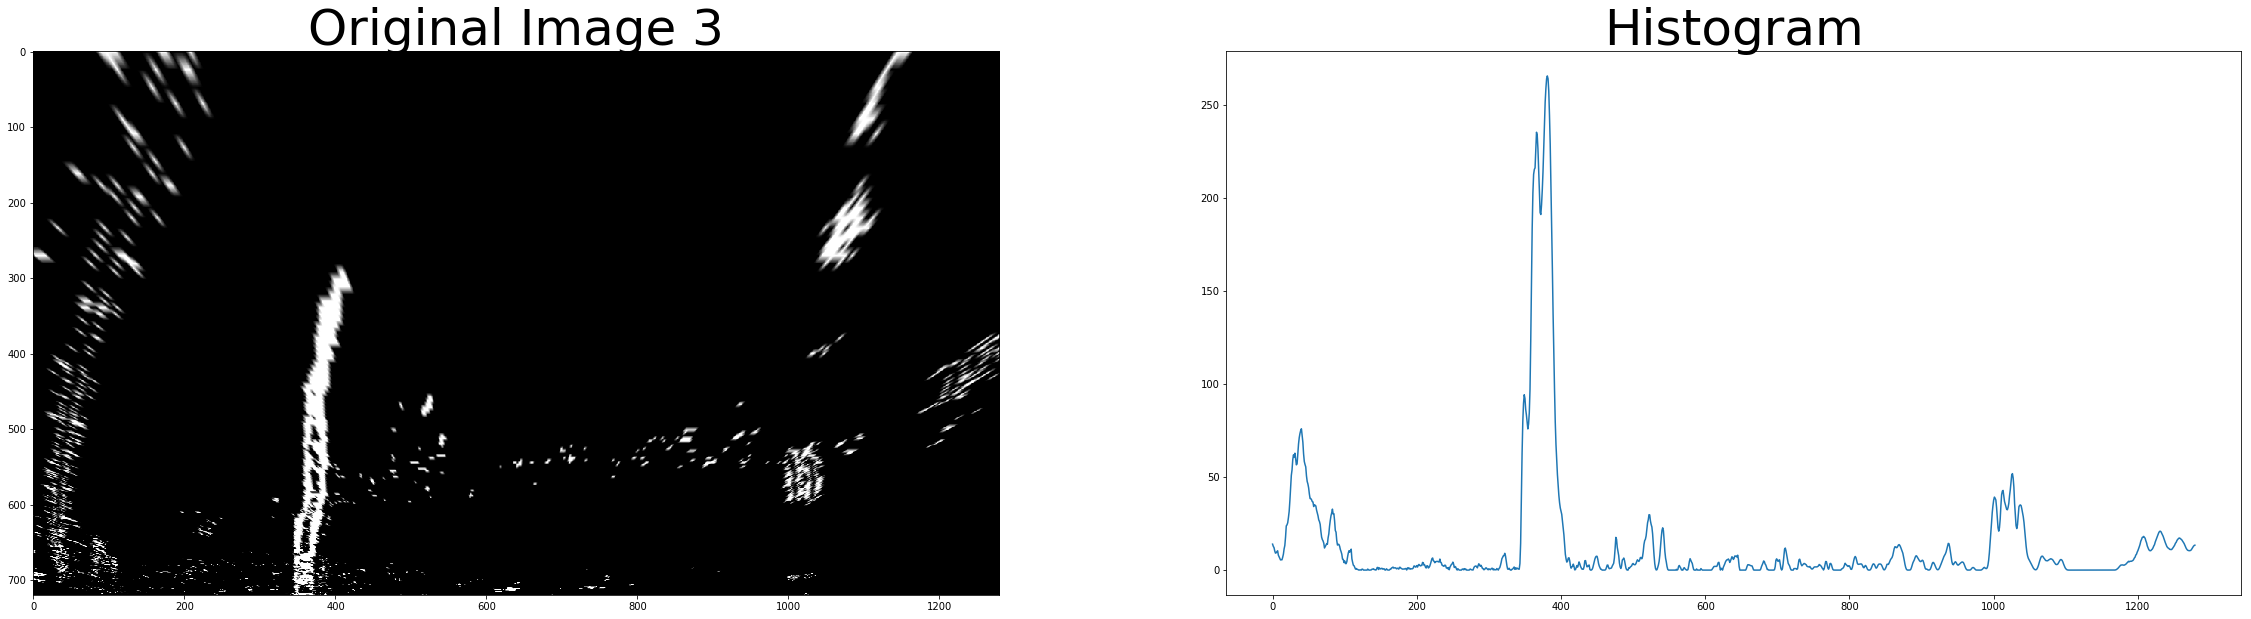

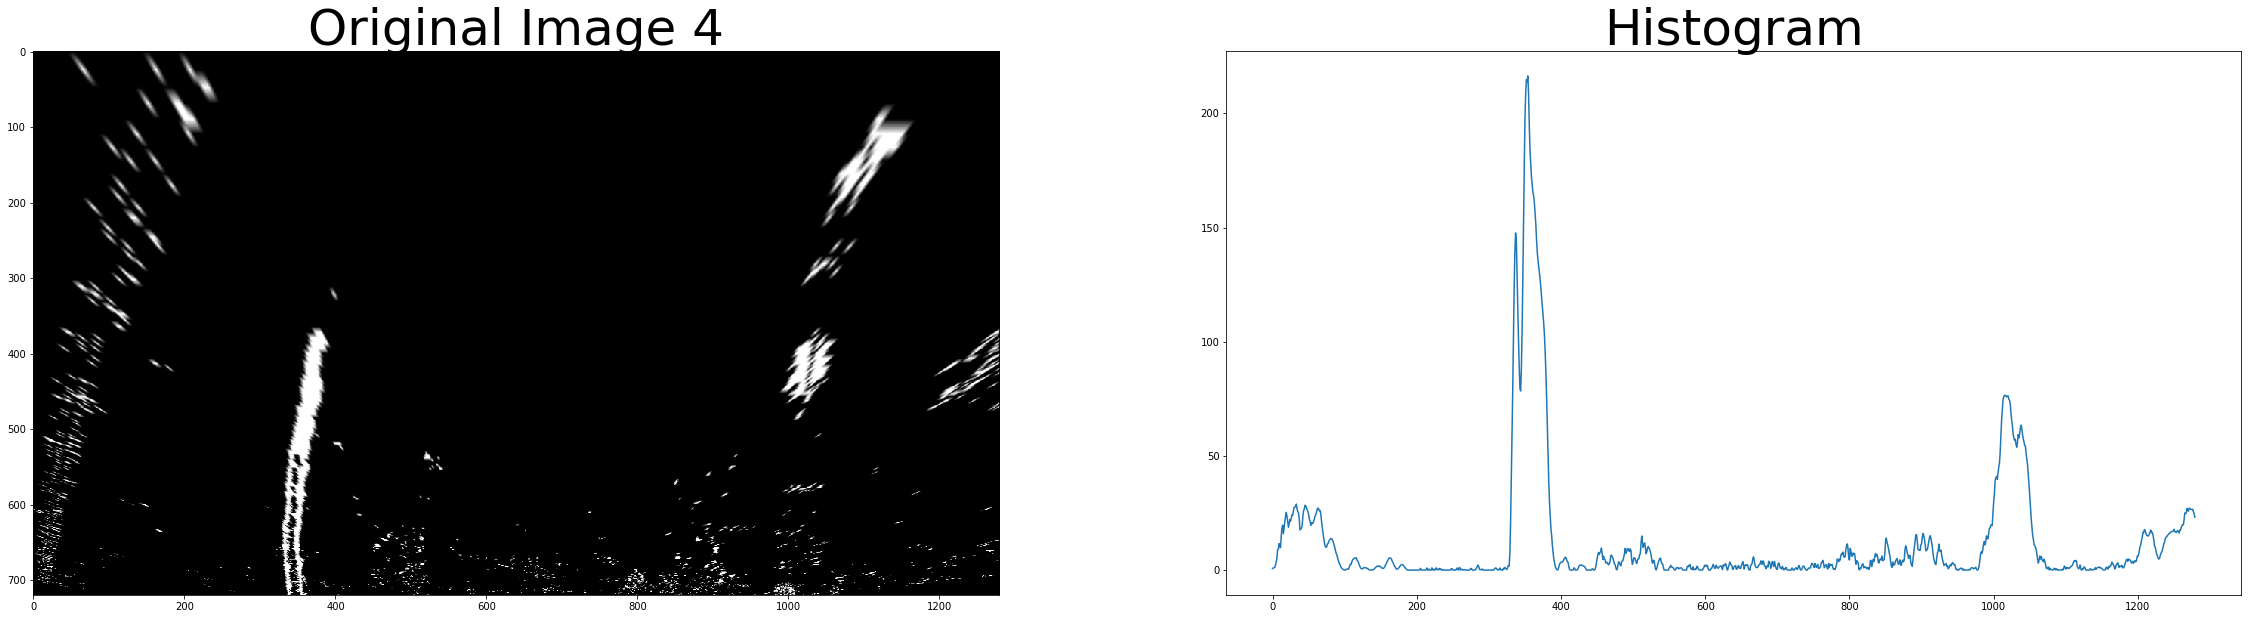

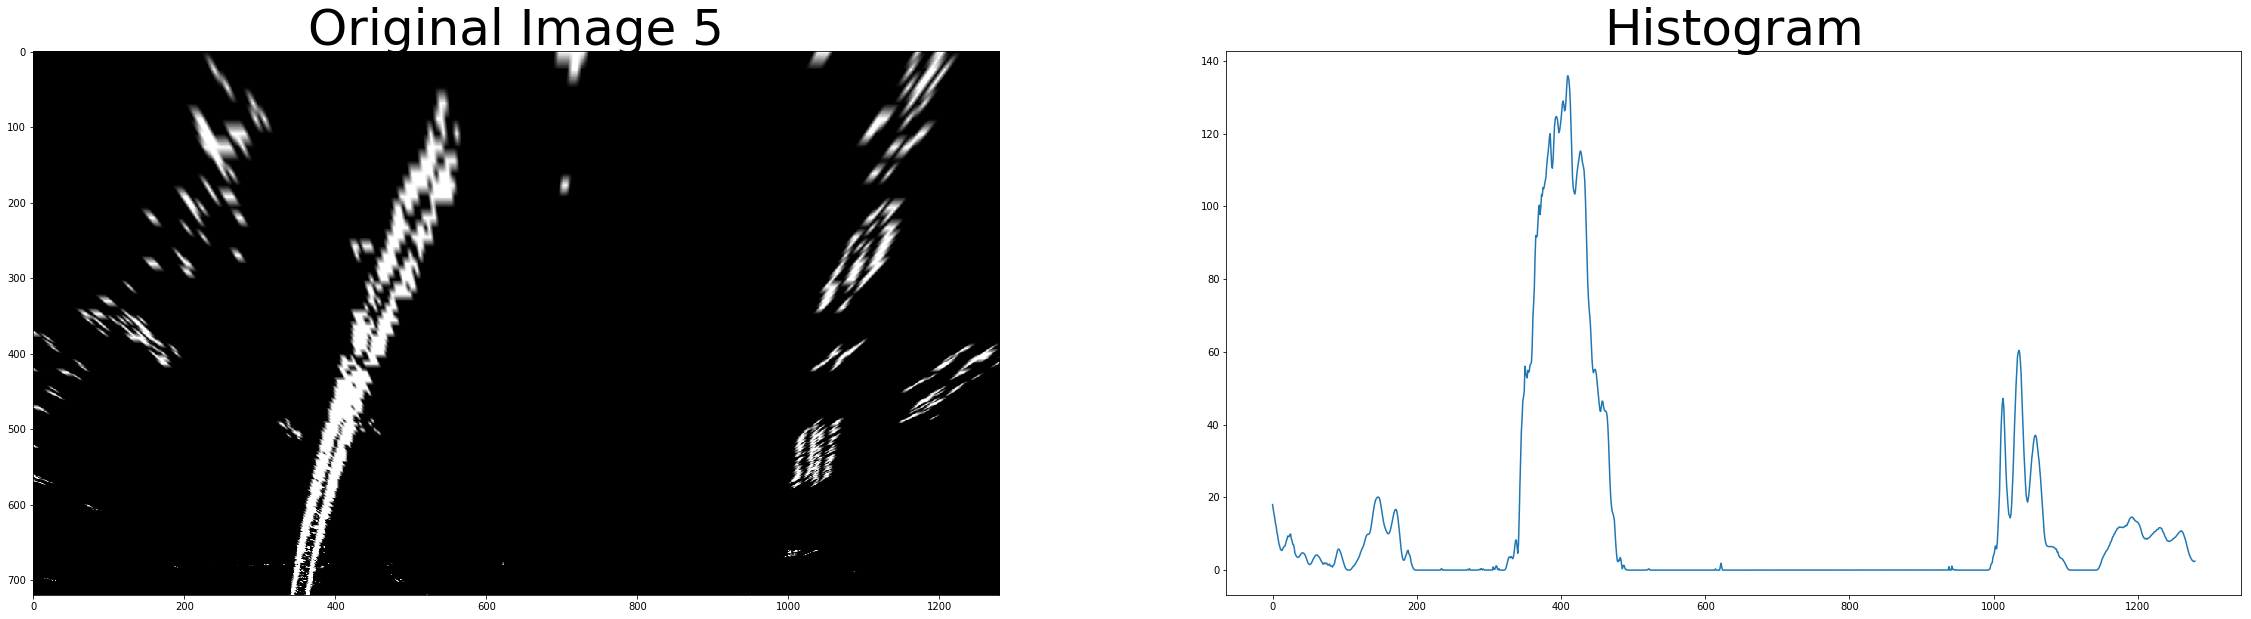

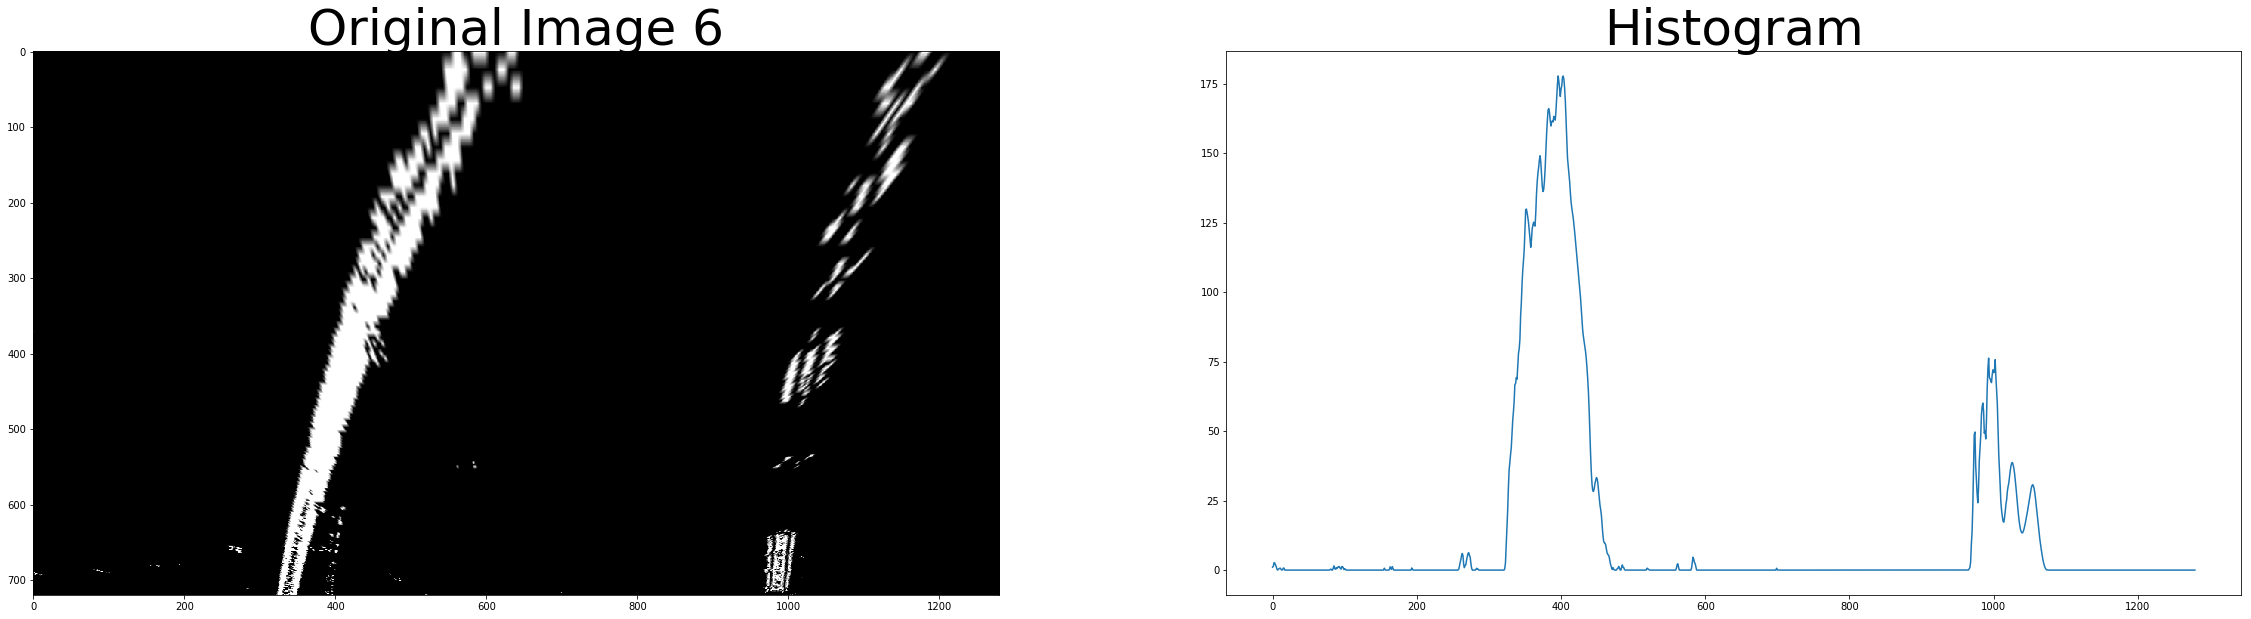

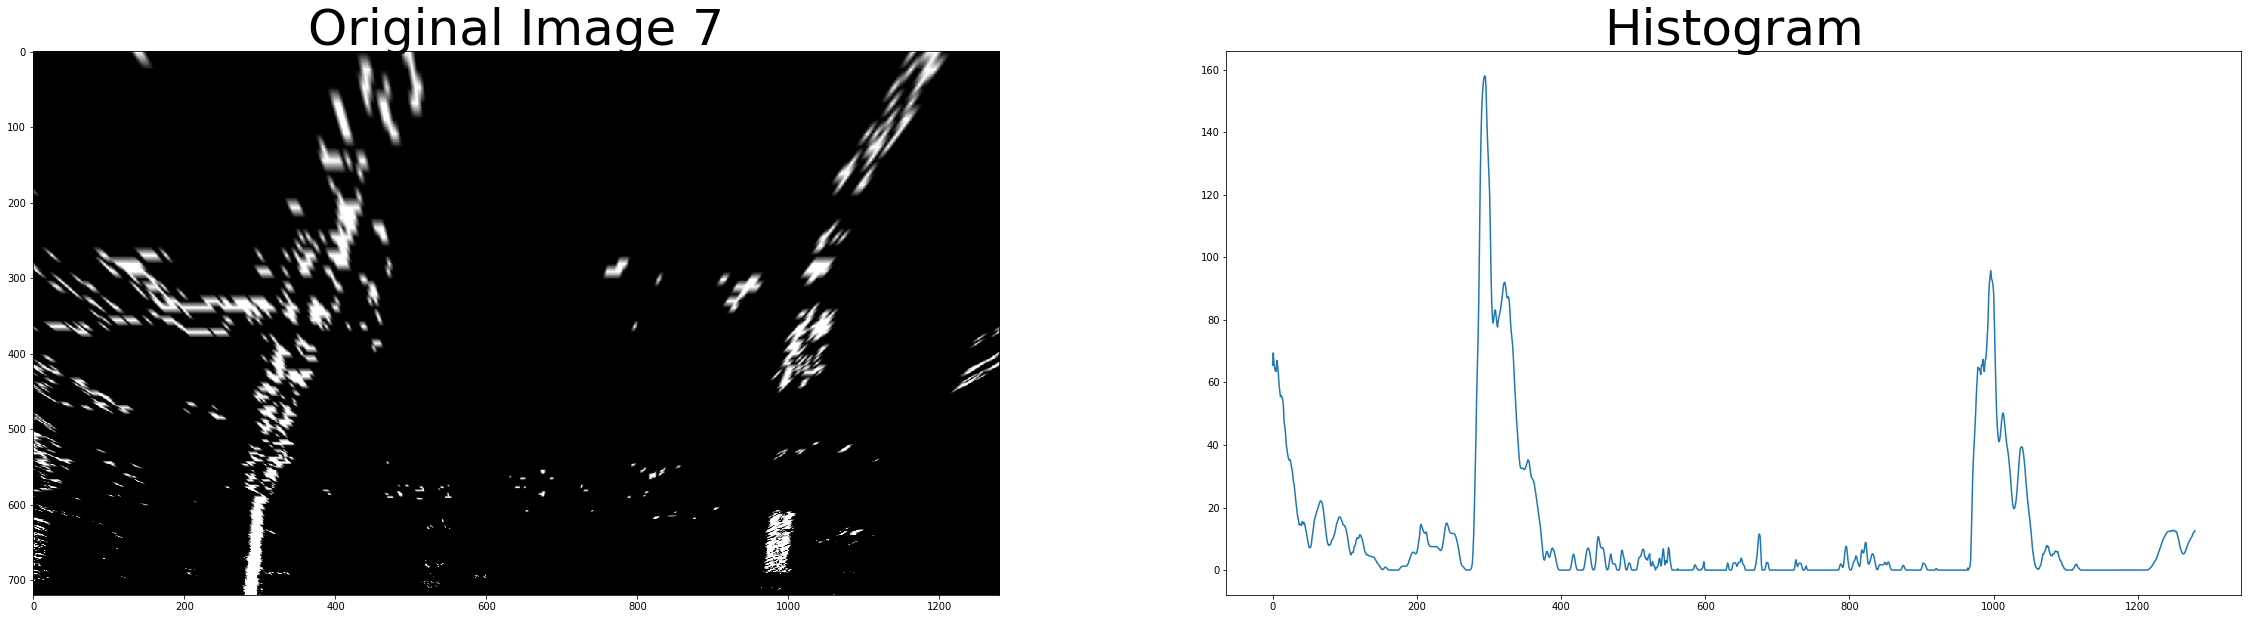

In [144]:
#for reference
for num, img in enumerate(test_binary_warped):        
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,10))
    ax1.imshow(test_perspective[num], cmap='gray')
    ax1.set_title('Original Image '+str(num), fontsize=50)
    ax2.plot(test_histogram[num])
    ax2.set_title('Histogram', fontsize=50)      


/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

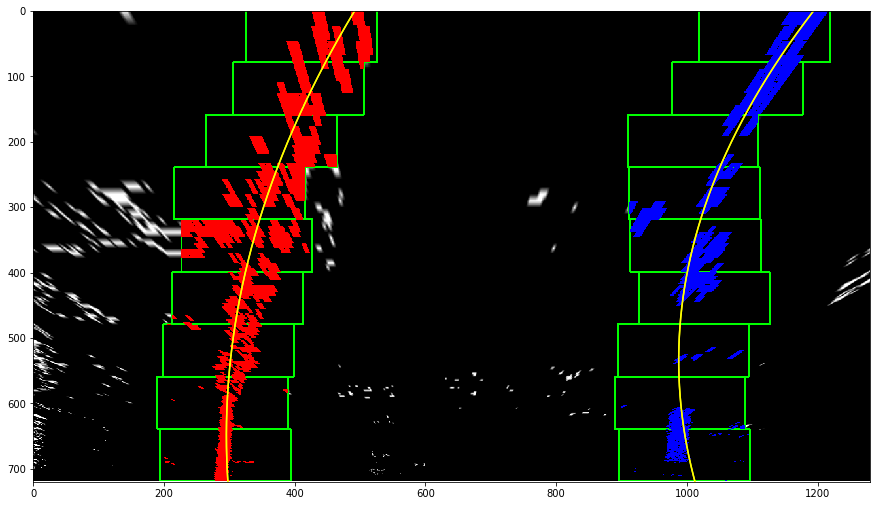

In [173]:
#Pipeline
#def findLane(binary_warped):    
binary_warped = np.copy(test_binary_warped[7])
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) 

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,1,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,1,0), 2) 
   
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]



f, ax = plt.subplots(figsize=(15,15))
ax.imshow(out_img)
ax.plot(left_fitx, ploty, color='yellow')
ax.plot(right_fitx, ploty, color='yellow')
#f.xlim(0, 1280)
#f.ylim(720, 0)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
#return left_fit, right_fit

(720, 0)

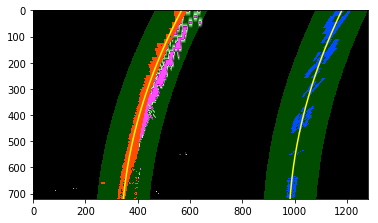

In [174]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
binary_warped = np.copy(test_binary_warped[6])
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [1, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 1]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,1, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,1, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


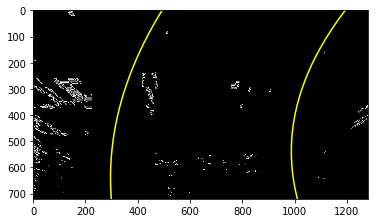

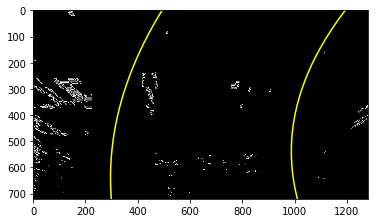

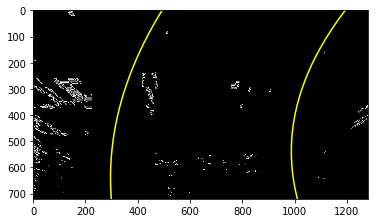

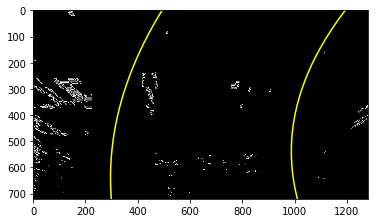

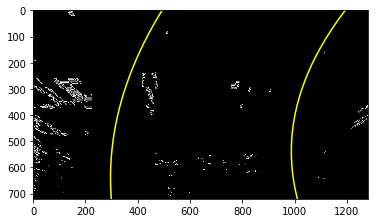

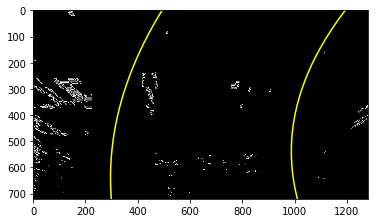

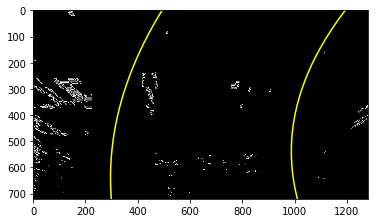

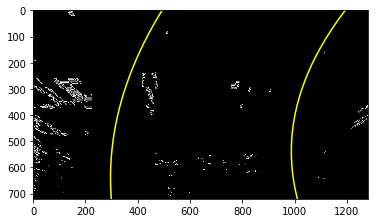

In [68]:
#for reference
for num, binary_warped in enumerate(test_binary_warped):    
    findLane(img)


In [ ]:
_